In [2]:
__depends__ = [
    "../../../data/database-results/phase-1/timestamp.txt",
    "../../../data/database-observations/timestamp.txt",
]
__dest__ = [
    "../../../figures/tas-obs-rcmip-cmip5-cmip6-comparison.pdf",
    "../../../figures/effrf-rcmip-comparison.pdf",
    "../../../figures/effrf-aerosols-rcmip-comparison.pdf",
    "../../../figures/effrf-total-aerosols-rcmip-comparison.pdf",
]

In [3]:
TAS_COMPARISON_FIGURE_PDF = __dest__[0]
EFFRF_COMPARISON_FIGURE_PDF = __dest__[1]
EFFRF_AEROSOLS_COMPARISON_FIGURE_PDF = __dest__[2]
EFFRF_PANEL_COMPARISON_FIGURE_PDF = __dest__[3]

In [4]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [5]:
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

# Historical comparisons

In [6]:
import glob
import logging
import os
import re
from pathlib import Path

import numpy as np
import pandas as pd
import scipy.stats
import tqdm.autonotebook as tqdman

from pymagicc.io import MAGICCData
from scmdata import ScmDataFrame, ScmRun
from scmdata.run import df_append

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import seaborn as sns

%matplotlib inline

/Users/znicholls/miniconda3/envs/rcmip/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


<IPython.core.display.Javascript object>

In [7]:
from utils import (
    aggregate_effective_aerosol_forcing,
    clean_labels,
    convert_scmdf_to_pyamdf_year_only,
    get_interest_period_mean,
    get_interest_period_slope,
    load_database_files,
    prep_str_for_filename,
    reduce_to_one_variant_per_model,
)

<IPython.core.display.Javascript object>

In [8]:
logger = logging.getLogger()

<IPython.core.display.Javascript object>

In [9]:
color_map_scenarios_base = {
    "ssp119": "AR6-SSP1-1.9",
    "ssp126": "AR6-SSP1-2.6",
    "ssp245": "AR6-SSP2-4.5",
    "ssp370": "AR6-SSP3-7.0",
    "ssp370-lowNTCF": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-gidden": "AR6-SSP3-LowNTCF",
    "ssp370-lowNTCF-aerchemmip": "AR6-SSP3-LowNTCF",
    "ssp434": "AR6-SSP4-3.4",
    "ssp460": "AR6-SSP4-6.0",
    "ssp585": "AR6-SSP5-8.5",
    "ssp534-over": "AR6-SSP5-3.4-OS",
    "historical": "black",
    "rcp26": "AR5-RCP-2.6",
    "rcp45": "AR5-RCP-4.5",
    "rcp60": "AR5-RCP-6.0",
    "rcp85": "AR5-RCP-8.5",
    "historical-cmip5": "tab:gray",
}

color_map_scenarios = {}
for k, v in color_map_scenarios_base.items():
    color_map_scenarios[k] = v
    color_map_scenarios["esm-{}".format(k)] = v
    color_map_scenarios["esm-{}-allGHG".format(k)] = v

<IPython.core.display.Javascript object>

In [10]:
color_map_models = {"Observations (Priestley Centre)": "black"}

<IPython.core.display.Javascript object>

## Load data

### Observations

In [11]:
OBS_PATH = os.path.join("..", "..", "..", "data", "database-observations")
OBS_PATH

'../../../data/database-observations'

<IPython.core.display.Javascript object>

In [12]:
db_obs = df_append(
    [ScmRun.from_nc(f) for f in glob.glob(os.path.join(OBS_PATH, "*.nc"))]
)
db_obs.head()

time                                                                                               1850-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.042412   

time                                                                                               1851-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.123588   

time                                                                                               1852-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.085588   

time                                                                                               1853-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.025588   

time                                                                                               1854-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.086588   

time                                                                                               1855-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K       0.087588   

time                                                                                               1856-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.040412   

time                                                                                               1857-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.138412   

time                                                                                               1858-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.074412   

time                                                                                               1859-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K      -0.012412   

time                                                                                               ...  \
region model       scenario   climatemodel                    variable                       unit  ...   
World  unspecified historical Observations (Priestley Centre) Surface Air Temperature Change K     ...   

time                                                                                               2009-01-01  \
region model       scenario   climatemodel                    variable                       unit               
World  unspecified historical Observations (Priestley C

<IPython.core.display.Javascript object>

In [13]:
db_obs["variable"]

0    Surface Air Temperature Change
Name: variable, dtype: object

<IPython.core.display.Javascript object>

### RCMIP results

In [14]:
RESULTS_PATH = os.path.join("..", "..", "..", "data", "database-results", "phase-1")
RESULTS_PATH

'../../../data/database-results/phase-1'

<IPython.core.display.Javascript object>

In [15]:
model_of_interest = [
    ".*acc2.*",
    ".*ar5ir.*",
    ".*cicero-scm.*",
    ".*escimo.*",
    ".*fair-1.5.*",
    ".*gir.*",
    ".*greb.*",
    ".*hector.*",
    ".*held-two-layer-uom.*",
    ".*magicc7.*",
    ".*mce.*",
    ".*oscar.*",
    ".*umd-emgc.*",
    ".*wasp.*",
]

results_files = list(Path(RESULTS_PATH).rglob("*.nc"))
results_files = [
    str(p)
    for p in results_files
    if any([bool(re.match(m, str(p))) for m in model_of_interest]) and "$" not in str(p)
]
print("Number of available files: {}".format(len(results_files)))
results_files[:5]

Number of available files: 10270


['../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_effective-radiative-forcing-anthropogenic-f-gases-pfc-cf4.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-mpi-esm1-2-hr-r1i1p1f1_world_emissions-f-gases-hfc-hfc125.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_cicero-scm-ecs3_world_radiative-forcing-anthropogenic-tropospheric-ozone.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-bcc-esm1-r1i1p1f1_world_radiative-forcing-anthropogenic-aerosols-aerosols-radiation-interactions.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_atmospheric-concentrations-f-gases-pfc-cf4-50th-quantile.nc']

<IPython.core.display.Javascript object>

In [16]:
variables_of_interest = [
    "Surface Air Temperature Change",
    #     "Surface Ocean Temperature Change",
    #     "Surface Air Ocean Blended Temperature Change",
    "effective-radiative-forcing\.nc",
    "Effective Radiative Forcing|Anthropogenic|Aerosols",
    "Effective Radiative Forcing|Anthropogenic|Other",
]

relevant_files = [
    str(p)
    for p in results_files
    if any(
        [
            bool(re.match(".*{}.*".format(prep_str_for_filename(v)), str(p)))
            for v in variables_of_interest
        ]
    )
]
print("Number of relevant files: {}".format(len(relevant_files)))
relevant_files[:5]

Number of relevant files: 843


['../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_effective-radiative-forcing-anthropogenic-other-other-wmghgs-50th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_magicc7.1.0.beta-ipsl-cm6a-lr-r1i1p1f2_world_effective-radiative-forcing-anthropogenic-aerosols-aerosols-radiation-interactions-nh3-fossil-and-industrial.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_fair-1.5-ens_world_effective-radiative-forcing-anthropogenic-aerosols-aerosols-cloud-interactions-50th-quantile.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_ar5ir2box-cmip6-bcc-csm2-mr-r1i1p1f1-calib_world_surface-air-temperature-change.nc',
 '../../../data/database-results/phase-1/rcmip-phase-1_mce,v1-1,cmip6-sam0-unicon-calib_world_effective-radiative-forcing.nc']

<IPython.core.display.Javascript object>

In [17]:
logging.getLogger("scmdata").setLevel(logging.WARNING)
db = load_database_files(relevant_files)
logging.getLogger("scmdata").setLevel(logging.INFO)
db.head()

time                                                                                                                 1750-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                                                                 1751-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                                                                 1752-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                                                                 1753-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                        

<IPython.core.display.Javascript object>

In [18]:
sorted(db["climatemodel"].unique())

['ACC2 | version 4.2',
 'Cicero-SCM',
 'Cicero-SCM-ECS3',
 'ESCIMO,rcmip,base',
 'FaIR-1.5-DEFAULT',
 'FaIR-1.5-ENS',
 'GIR (3 box)',
 'GREB-v1.0.1-ECMWF_IFS-ALL',
 'MAGICC7.1.0.beta-rcmip-phase-1',
 'MAGICC7.1.0.beta_AWI-CM-1-1-MR_R1I1P1F1',
 'MAGICC7.1.0.beta_BCC-CSM2-MR_R1I1P1F1',
 'MAGICC7.1.0.beta_BCC-ESM1_R1I1P1F1',
 'MAGICC7.1.0.beta_CANESM5_R10I1P1F1',
 'MAGICC7.1.0.beta_CANESM5_R1I1P1F1',
 'MAGICC7.1.0.beta_CANESM5_R1I1P2F1',
 'MAGICC7.1.0.beta_CESM2-WACCM_R1I1P1F1',
 'MAGICC7.1.0.beta_CESM2_R1I1P1F1',
 'MAGICC7.1.0.beta_CNRM-CM6-1-HR_R1I1P1F2',
 'MAGICC7.1.0.beta_CNRM-CM6-1_R1I1P1F2',
 'MAGICC7.1.0.beta_CNRM-ESM2-1_R1I1P1F2',
 'MAGICC7.1.0.beta_E3SM-1-0_R1I1P1F1',
 'MAGICC7.1.0.beta_EC-EARTH3-VEG_R1I1P1F1',
 'MAGICC7.1.0.beta_FGOALS-G3_R1I1P1F1',
 'MAGICC7.1.0.beta_GISS-E2-1-G_R1I1P1F1',
 'MAGICC7.1.0.beta_GISS-E2-1-H_R1I1P1F1',
 'MAGICC7.1.0.beta_GISS-E2-2-G_R1I1P1F1',
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R10I1P1F1',
 'MAGICC7.1.0.beta_IPSL-CM6A-LR_R1I1P1F1',
 'MAGICC7.1.0.beta_I

<IPython.core.display.Javascript object>

### CMIP5 and CMIP6 data

In [19]:
CMIP_PROCESSED_DATA_PATH = os.path.join("..", "..", "..", "data", "cmip-output")
CMIP_PROCESSED_DATA_PATH

'../../../data/cmip-output'

<IPython.core.display.Javascript object>

In [20]:
def load_tas_file(f):
    out = MAGICCData(f)
    metadata = out.metadata
    assert out["variable"].unique().tolist() == ["tas"]
    out.set_meta("Surface Air Temperature Change", "variable")
    try:
        source_id = out.metadata["(child) source_id"]
        variant_id = out.metadata["(child) variant_label"]
        cmip = "CMIP6"
    except KeyError:
        source_id = out.metadata["(child) model_id"]
        variant_id = os.path.basename(f).split("_")[-2]
        cmip = "CMIP5"

    out.set_meta(source_id, "source_id")
    out.set_meta("_".join([source_id, variant_id]), "climatemodel")
    out.set_meta(out.metadata["(child) experiment_id"], "scenario")
    out.set_meta(cmip, "mip_era")

    out = out.timeseries().reset_index().drop(["todo", "climate_model"], axis="columns")

    out = MAGICCData(out)
    out.metadata = metadata

    return out


cmip_files = glob.glob(os.path.join(CMIP_PROCESSED_DATA_PATH, "NORMED*tas*.MAG"))

db_cmip = df_append(
    [
        ScmRun(load_tas_file(f).filter(region="World").timeseries())
        for f in tqdman.tqdm(cmip_files)
    ]
)
db_cmip.head()

time                                                                                                            0001-07-01 00:00:00  \
model       scenario   region variable                       unit source_id      mip_era climatemodel                                 
unspecified hist-noLu  World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r1i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    GISS-E2-H      CMIP5   GISS-E2-H_r4i1p3                       NaN   
            ssp370     World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r2i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    MIROC-ESM-CHEM CMIP5   MIROC-ESM-CHEM_r1i1p1                  NaN   
            ssp245-GHG World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r3i1p1f1                  NaN   

time                                                                                                            0002-07-01 00:00:00  \
model       scenario   region variable                       unit source_id      mip_era climatemodel                                 
unspecified hist-noLu  World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r1i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    GISS-E2-H      CMIP5   GISS-E2-H_r4i1p3                       NaN   
            ssp370     World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r2i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    MIROC-ESM-CHEM CMIP5   MIROC-ESM-CHEM_r1i1p1                  NaN   
            ssp245-GHG World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r3i1p1f1                  NaN   

time                                                                                                            0003-07-01 00:00:00  \
model       scenario   region variable                       unit source_id      mip_era climatemodel                                 
unspecified hist-noLu  World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r1i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    GISS-E2-H      CMIP5   GISS-E2-H_r4i1p3                       NaN   
            ssp370     World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r2i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    MIROC-ESM-CHEM CMIP5   MIROC-ESM-CHEM_r1i1p1                  NaN   
            ssp245-GHG World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r3i1p1f1                  NaN   

time                                                                                                            0004-07-01 00:00:00  \
model       scenario   region variable                       unit source_id      mip_era climatemodel                                 
unspecified hist-noLu  World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r1i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    GISS-E2-H      CMIP5   GISS-E2-H_r4i1p3                       NaN   
            ssp370     World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r2i1p1f1                  NaN   
            historical World  Surface Air Temperature Change K    MIROC-ESM-CHEM CMIP5   MIROC-ESM-CHEM_r1i1p1                  NaN   
            ssp245-GHG World  Surface Air Temperature Change K    IPSL-CM6A-LR   CMIP6   IPSL-CM6A-LR_r3i1p1f1                  NaN   

time                                                                                                            0005-07-01 00:00:00  \
model       scenario   region variable                       unit source_id      

<IPython.core.display.Javascript object>

## Plot

### Temperature

In [21]:
matplotlib.rcParams["figure.figsize"] = (8, 8)
matplotlib.rcParams["font.size"] = 8

<IPython.core.display.Javascript object>

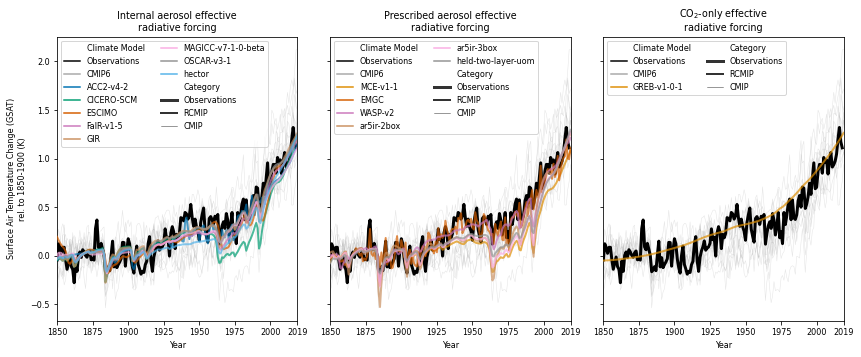

<IPython.core.display.Javascript object>

In [22]:
variable_to_plot = [
    "Surface Air Temperature Change",
    "Surface Air Temperature Change|50th quantile",
]
region_to_plot = "World"
scenario_obs = "historical"
scenario_models = "ssp585"
scenario_cmip = ["ssp585", "rcp85"]
rcmip_climatemodel_ignore_filter = [
    "*CALIB*",
    "MAGICC*_*",
    "*CMIP5-mean",
    "FaIR-1.5-ENS",
    "WASP,2,PROB-hist",
    "Cicero-SCM",
    "MCE,v1-1,DEFAULT",
    "MCE,v1-1,PROB",
    "UMD-EMGC*PROB",
]
broken_cmip5_climatemodel = [
    "HadGEM2-CC_r1i1p1",
    "HadGEM2-CC_r2i1p1",
    "HadGEM2-CC_r3i1p1",
]

years_to_plot = range(1850, 2020)
reference_period = (1961, 1990)  # bounds are inclusive
reference_period = (1850, 1900)  # bounds are inclusive


def prep_for_plot(idf):
    udf = idf.relative_to_ref_period_mean(
        year=range(reference_period[0], reference_period[1] + 1)
    )

    return udf


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(TAS_COMPARISON_FIGURE_PDF)

pdf_obs = prep_for_plot(
    db_obs.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_obs,
        year=years_to_plot,
    )
).long_data(time_axis="year")

pdf_rcmip = prep_for_plot(
    db.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_models,
        year=years_to_plot,
    )
    .filter(climatemodel=rcmip_climatemodel_ignore_filter, keep=False)
    .append(
        db.filter(  # ACC2 only has esm results
            variable=variable_to_plot,
            region=region_to_plot,
            scenario="esm-" + scenario_models + "-allGHG",
            year=years_to_plot,
            climatemodel="*ACC2*",
        )
    )
).long_data(time_axis="year")


prescribed_erf_str = "Prescribed aerosol effective\nradiative forcing"
internal_erf_str = "Internal aerosol effective\nradiative forcing"
co2_only_str = "CO$_2$-only effective\nradiative forcing"


def determine_model_category(model):
    if model.startswith("GREB"):
        return co2_only_str

    if any([model.startswith(v) for v in ("ar5ir", "held-two", "MCE", "WASP", "UMD")]):
        return prescribed_erf_str

    return internal_erf_str


pdf_rcmip["Model Type"] = pdf_rcmip["climatemodel"].apply(determine_model_category)

pdf_cmip = prep_for_plot(
    db_cmip.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_cmip,
        year=years_to_plot,
    ).filter(climatemodel=broken_cmip5_climatemodel, keep=False)
)

pdf_cmip = (
    reduce_to_one_variant_per_model(pdf_cmip)
    .filter(mip_era="CMIP6")
    .long_data(time_axis="year")
)

sizes = {"Observations": 3, "CMIP": 0.5, "RCMIP": 2}

n_model_type = len(pdf_rcmip["Model Type"].unique())
fig, axes = plt.subplots(figsize=(12, 5), nrows=1, ncols=3, sharey=True)
axes = axes.flatten()

for i, label in enumerate([internal_erf_str, prescribed_erf_str, co2_only_str]):
    df = pdf_rcmip[pdf_rcmip["Model Type"] == label].copy()

    df = pd.concat([pdf_obs, df, pdf_cmip], sort=True)

    df["Climate Model"] = df["climatemodel"]
    df.loc[df["mip_era"] == "CMIP5", "Climate Model"] = "CMIP5"
    df.loc[df["mip_era"] == "CMIP6", "Climate Model"] = "CMIP6"

    climatemodels = sorted(df["Climate Model"].unique())
    sns_colours = sns.color_palette("colorblind", len(climatemodels))

    obs_key = [
        cm for cm in pdf_obs["climatemodel"].unique() if cm.startswith("Observations")
    ][0]

    palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}
    palette[obs_key] = "black"
    #     palette["CMIP5"] = "darkgray"
    palette["CMIP6"] = "darkgray"

    df["Category"] = "RCMIP"
    df.loc[~df["source_id"].isnull(), "Category"] = "CMIP"
    df.loc[
        df["climatemodel"].str.startswith("Observations"), "Category"
    ] = "Observations"

    climatemodels = sorted(df["Climate Model"].unique())
    hue_order = (
        [obs_key]
        #         + ["CMIP5", "CMIP6"]
        + ["CMIP6"]
        + [
            cm
            for cm in sorted(climatemodels)
            if (cm != obs_key) and (cm not in ["CMIP5", "CMIP6"])
        ]
    )

    ax = axes[i]
    sns.lineplot(
        data=df,
        x="time",
        y="value",
        units="climatemodel",
        hue="Climate Model",
        palette=palette,
        #         style="Climate Model",
        #         markers=["D", "o", "^", "v", "<", ">", "8", "s", "p", "*"],
        #         markevery=20,
        hue_order=hue_order,
        dashes=False,
        ax=ax,
        size="Category",
        sizes=sizes,
        estimator=None,
    )
    ax.set_title(label)

    clean_labels(ax, ignore=["Category", "Climate Model"])
    legend = ax.legend(loc="upper left", ncol=2)

    for l in ax.get_lines():
        if l.get_linewidth() == 3:
            l.set_zorder(10)
            l.set_alpha(1)
        elif l.get_linewidth() == 2:
            l.set_zorder(11)
            l.set_alpha(0.7)
        else:
            l.set_alpha(0.3)

    ax.set_ylabel(
        "Surface Air Temperature Change (GSAT)\nrel. to {}-{} (K)".format(
            reference_period[0], reference_period[1]
        )
    )
    ax.set_xlabel("Year")
    ax.set_xlim([1850, 2019])
    #     ax.tick_params(right=True)
    ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)

pdf_to_save.close()

In [22]:
TAS_COMPARISON_FIGURE_PDF

'../../../figures/tas-obs-rcmip-cmip5-cmip6-comparison.pdf'

<IPython.core.display.Javascript object>

#### Some basic analysis too

In [23]:
interest_period = (2000, 2019)  # inclusive bounds

<IPython.core.display.Javascript object>

In [24]:
interest_period_long = (1970, 2000)  # inclusive bounds
interest_period_long = (1989, 2019)  # inclusive bounds

<IPython.core.display.Javascript object>

In [25]:
pdf_rcmip_analysis_interest_period_mean = get_interest_period_mean(
    pdf_rcmip, interest_period
)
pdf_rcmip_analysis_interest_period_mean.to_frame().head()

0
model          scenario region variable                       unit climatemodel              model type                                      reference_period_end_year reference_period_start_year unit_context          
GREB           ssp585   World  Surface Air Temperature Change K    GREB-v1.0.1-ECMWF_IFS-ALL CO$_2$-only effective\nradiative forcing        1900                      1850                        not_required  1.058398
Not_applicable ssp585   World  Surface Air Temperature Change K    UMD-EMGC,5,DEFAULT        Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.917307
REMIND-MAGPIE  ssp585   World  Surface Air Temperature Change K    OSCARv3.1                 Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  1.020832
                                                                   ar5ir2box-ECS-3K          Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.969410
                                                                   ar5ir3box-ECS-3K          Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.953624

<IPython.core.display.Javascript object>

In [26]:
pdf_rcmip_analysis_interest_period_mean.describe()

count    15.000000
mean      0.949437
std       0.066428
min       0.801538
25%       0.904030
50%       0.959903
75%       0.978200
max       1.058398
dtype: float64

<IPython.core.display.Javascript object>

In [27]:
pdf_obs["variable"].unique()

array(['Surface Air Temperature Change'], dtype=object)

<IPython.core.display.Javascript object>

In [28]:
get_interest_period_mean(pdf_rcmip, interest_period_long).describe()

count    15.000000
mean      0.793150
std       0.078710
min       0.623523
25%       0.756794
50%       0.794194
75%       0.820448
max       0.957685
dtype: float64

<IPython.core.display.Javascript object>

In [29]:
get_interest_period_mean(pdf_obs, interest_period).describe()

count    1.000000
mean     0.990198
std           NaN
min      0.990198
25%      0.990198
50%      0.990198
75%      0.990198
max      0.990198
dtype: float64

<IPython.core.display.Javascript object>

In [30]:
get_interest_period_mean(pdf_obs, interest_period_long).describe()

count    1.000000
mean     0.872186
std           NaN
min      0.872186
25%      0.872186
50%      0.872186
75%      0.872186
max      0.872186
dtype: float64

<IPython.core.display.Javascript object>

In [31]:
get_interest_period_mean(pdf_cmip, interest_period).describe()

count    13.000000
mean      1.091910
std       0.259781
min       0.685526
25%       0.885441
50%       1.128420
75%       1.239079
max       1.560572
dtype: float64

<IPython.core.display.Javascript object>

In [32]:
get_interest_period_mean(pdf_cmip, interest_period_long).describe()

count    13.000000
mean      0.918197
std       0.248380
min       0.553550
25%       0.684705
50%       0.916909
75%       1.055904
max       1.332904
dtype: float64

<IPython.core.display.Javascript object>

In [33]:
pdf_rcmip_analysis_interest_period_slope = get_interest_period_slope(
    pdf_rcmip, interest_period
)
pdf_rcmip_analysis_interest_period_slope.to_frame()

0
model          scenario          region variable                                     unit climatemodel                   model type                                      reference_period_end_year reference_period_start_year unit_context          
GREB           ssp585            World  Surface Air Temperature Change               K    GREB-v1.0.1-ECMWF_IFS-ALL      CO$_2$-only effective\nradiative forcing        1900                      1850                        not_required  0.020358
Not_applicable ssp585            World  Surface Air Temperature Change               K    UMD-EMGC,5,DEFAULT             Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.016515
REMIND-MAGPIE  ssp585            World  Surface Air Temperature Change               K    OSCARv3.1                      Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.019559
                                                                                          ar5ir2box-ECS-3K               Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.024203
                                                                                          ar5ir3box-ECS-3K               Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.030179
                                                                                          hector|1d51f|DEFAULT           Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.027310
                                                                                          held-two-layer-uom-ECS-3K      Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.031874
not applicable ssp585            World  Surface Air Temperature Change               K    ESCIMO,rcmip,base              Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.024710
not_applicable esm-ssp585-allGHG World  Surface Air Temperature Change               K    ACC2 | version 4.2             Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.022625
               ssp585            World  Surface Air Temperature Change               K    MCE,v1-1,ECS3K                 Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.025499
unspecified    ssp585            World  Surface Air Temperature Change               K    Cicero-SCM-ECS3                Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.030389
                                                                                          FaIR-1.5-DEFAULT               Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.021068
                                                                                          GIR (3 box)                    Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.022041
                                                                                          MAGICC7.1.0.beta-rcmip-phase-1 Internal aerosol effective\nradiative forcing   1900                      1850                        not_required  0.022759
                                        Surface Air Temperature Change|50th quantile K    WASP,2,PROB-ECS3               Prescribed aerosol effective\nradiative forcing 1900                      1850                        not_required  0.021877

<IPython.core.display.Javascript object>

In [34]:
pdf_rcmip_analysis_interest_period_slope.describe()

count    15.000000
mean      0.024064
std       0.004343
min       0.016515
25%       0.021473
50%       0.022759
75%       0.026404
max       0.031874
dtype: float64

<IPython.core.display.Javascript object>

In [35]:
get_interest_period_slope(pdf_rcmip, interest_period_long).describe()

count    15.000000
mean      0.026943
std       0.005399
min       0.018739
25%       0.023141
50%       0.026681
75%       0.030764
max       0.034347
dtype: float64

<IPython.core.display.Javascript object>

In [36]:
get_interest_period_slope(pdf_obs, interest_period).describe()

count    1.000000
mean     0.019494
std           NaN
min      0.019494
25%      0.019494
50%      0.019494
75%      0.019494
max      0.019494
dtype: float64

<IPython.core.display.Javascript object>

In [37]:
get_interest_period_slope(pdf_obs, interest_period_long).describe()

count    1.000000
mean     0.021127
std           NaN
min      0.021127
25%      0.021127
50%      0.021127
75%      0.021127
max      0.021127
dtype: float64

<IPython.core.display.Javascript object>

In [38]:
get_interest_period_slope(pdf_cmip, interest_period).describe()

count    13.000000
mean      0.025234
std       0.008858
min       0.011383
25%       0.020260
50%       0.024390
75%       0.026848
max       0.039716
dtype: float64

<IPython.core.display.Javascript object>

In [39]:
get_interest_period_slope(pdf_cmip, interest_period_long).describe()

count    13.000000
mean      0.029481
std       0.006559
min       0.017832
25%       0.026572
50%       0.029567
75%       0.032247
max       0.040805
dtype: float64

<IPython.core.display.Javascript object>

### Effective radiative forcing

In [40]:
db.head()

time                                                                                                                 1750-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                                                                 1751-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                                                                 1752-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                                                                 1753-01-01 00:00:00  \
region model       scenario      climatemodel variable                                           unit  unit_context                        
World  unspecified 1pctCO2       FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-4xext FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-bgc   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-cdr   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   
                   1pctCO2-rad   FaIR-1.5-ENS Effective Radiative Forcing|Anthropogenic|Other... W/m^2 not_required                  NaN   

time                                                                        

<IPython.core.display.Javascript object>

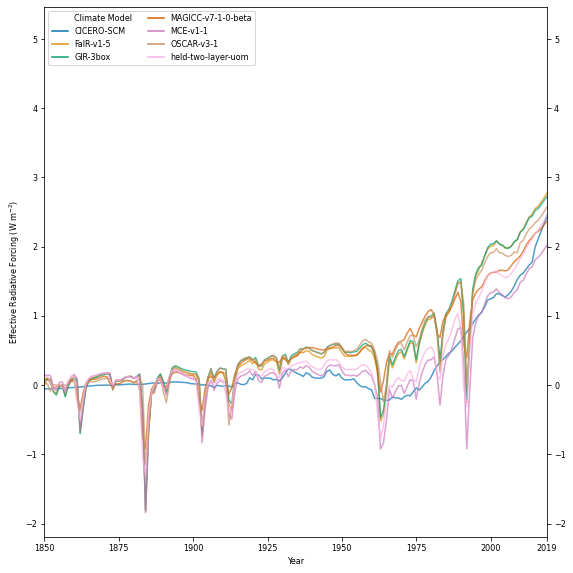

<IPython.core.display.Javascript object>

In [41]:
variable_to_plot = [
    "Effective Radiative Forcing",
    "Effective Radiative Forcing|50th quantile",
]
region_to_plot = "World"
scenario_models = "ssp585"
broken_rcmip_results = ["*ESCIMO*"]  # up around 200...

years_to_plot = range(1850, 2050)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(EFFRF_COMPARISON_FIGURE_PDF)

fig, ax = plt.subplots(nrows=1, ncols=1)

pdf_rcmip = prep_for_plot(
    db.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_models,
        year=years_to_plot,
    ).filter(
        climatemodel=rcmip_climatemodel_ignore_filter + broken_rcmip_results, keep=False
    )
).long_data(time_axis="year")

pdf_sns = pd.concat([pdf_rcmip], sort=True)

pdf_sns["Category"] = "RCMIP"
sizes = {"Observations": 3, "CMIP": 0.5, "RCMIP": 2}

pdf_sns["Climate Model"] = pdf_sns["climatemodel"]

climatemodels = sorted(pdf_sns["Climate Model"].unique())
hue_order = sorted(climatemodels)
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}

dashes_set = ("", (3, 3))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}

sns.lineplot(
    data=pdf_sns,
    x="time",
    y="value",
    units="climatemodel",
    hue="Climate Model",
    hue_order=hue_order,
    style="Climate Model",
    dashes=dashes,
    palette=palette,
    ax=ax,
    estimator=None,
    alpha=0.7,
)

clean_labels(ax, ignore=["Category", "Climate Model"])
ax.legend(loc="upper left", ncol=2)

ax.set_ylabel("Effective Radiative Forcing (W m$^{-2}$)")
ax.set_xlabel("Year")
ax.set_xlim([1850, 2019])
ax.tick_params(labelright=True, right=True)
ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()

### Effective radiative forcing due to aerosols

In [42]:
db_plus_agg = aggregate_effective_aerosol_forcing(db)
db_plus_agg.filter(variable="*Aerosols")["variable"].unique()

Filtered ScmRun is empty!
/Users/znicholls/Documents/AGCEC/RCMIP/rcmip/notebooks/results/phase-1/utils.py:51: UserWarning: No Effective Radiative Forcing|Anthropogenic|Aerosols data for OSCARv3.0
  warnings.warn("No {} data for {}".format(var_to_agg, cm))
Filtered ScmRun is empty!
Filtered ScmRun is empty!


array(['Effective Radiative Forcing|Anthropogenic|Aerosols',
       'Effective Radiative Forcing|Anthropogenic|Aerosols|Aerosols-radiation Interactions|Other|Secondary Organic Aerosols'],
      dtype=object)

<IPython.core.display.Javascript object>

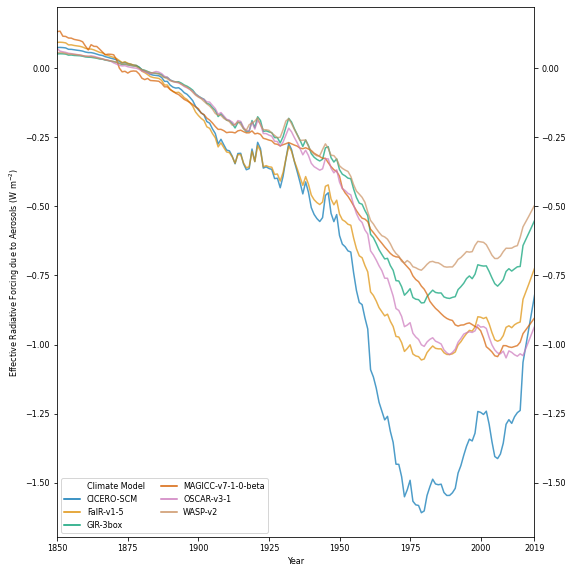

<IPython.core.display.Javascript object>

In [43]:
variable_to_plot = [
    "Effective Radiative Forcing|Anthropogenic|Aerosols",
    "Effective Radiative Forcing|Anthropogenic|Aerosols|50th quantile",
]
region_to_plot = "World"
scenario_models = "ssp585"
broken_rcmip_results = ["*ESCIMO*"]  # up around 200...

years_to_plot = range(1850, 2050)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(
    EFFRF_AEROSOLS_COMPARISON_FIGURE_PDF
)

fig, ax = plt.subplots(nrows=1, ncols=1)

pdf_rcmip = prep_for_plot(
    db_plus_agg.filter(
        variable=variable_to_plot,
        region=region_to_plot,
        scenario=scenario_models,
        year=years_to_plot,
    ).filter(
        climatemodel=rcmip_climatemodel_ignore_filter + broken_rcmip_results, keep=False
    )
).long_data(time_axis="year")

pdf_sns = pd.concat([pdf_rcmip], sort=True)

pdf_sns["Category"] = "RCMIP"
sizes = {"Observations": 3, "CMIP": 0.5, "RCMIP": 2}

pdf_sns["Climate Model"] = pdf_sns["climatemodel"]

climatemodels = sorted(pdf_sns["Climate Model"].unique())
hue_order = sorted(climatemodels)
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}

dashes_set = ("", (3, 3))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}

sns.lineplot(
    data=pdf_sns,
    x="time",
    y="value",
    units="climatemodel",
    hue="Climate Model",
    hue_order=hue_order,
    style="Climate Model",
    dashes=dashes,
    palette=palette,
    ax=ax,
    estimator=None,
    alpha=0.7,
)

clean_labels(ax, ignore=["Category", "Climate Model"])
ax.legend(loc="lower left", ncol=2)

ax.set_ylabel("Effective Radiative Forcing due to Aerosols (W m$^{-2}$)")
ax.set_xlabel("Year")
ax.set_xlim([1850, 2019])
ax.tick_params(labelright=True, right=True)
ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()

In [44]:
# thanks https://stackoverflow.com/a/952952
flatten = lambda l: [item for sublist in l for item in sublist]

<IPython.core.display.Javascript object>

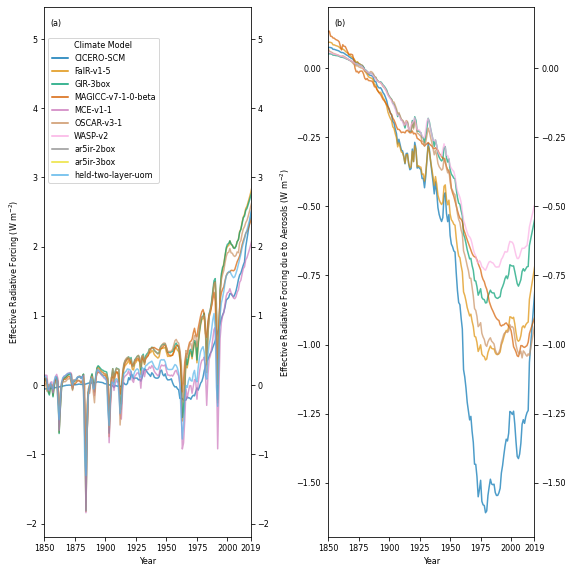

<IPython.core.display.Javascript object>

In [45]:
variable_to_plot_filters = [
    ["Effective Radiative Forcing", "Effective Radiative Forcing|50th quantile"],
    [
        "Effective Radiative Forcing|Anthropogenic|Aerosols",
        "Effective Radiative Forcing|Anthropogenic|Aerosols|50th quantile",
    ],
]
fig, axes_raw = plt.subplots(nrows=1, ncols=2)
axes = [axes_raw[0], axes_raw[1]]
ylabels = [
    "Effective Radiative Forcing (W m$^{-2}$)",
    "Effective Radiative Forcing due to Aerosols (W m$^{-2}$)",
]
annotations = ["(a)", "(b)"]
region_to_plot = "World"
scenario_models = "ssp585"
rcmip_climatemodel_calib_filter = ["*CALIB*", "MAGICC*_*", "*CMIP5-mean"]
broken_rcmip_results = ["*ESCIMO*"]  # up around 200...

years_to_plot = range(1850, 2050)


pdf_to_save = matplotlib.backends.backend_pdf.PdfPages(
    EFFRF_PANEL_COMPARISON_FIGURE_PDF
)

db_plus_agg_cms = db_plus_agg.filter(variable=flatten(variable_to_plot_filters)).filter(
    climatemodel=rcmip_climatemodel_ignore_filter + broken_rcmip_results, keep=False
)
climatemodels = sorted(db_plus_agg_cms["climatemodel"].unique())
hue_order = sorted(climatemodels)
sns_colours = sns.color_palette("colorblind", len(climatemodels))

palette = {cm: sns_colours[i] for i, cm in enumerate(climatemodels)}

dashes_set = ("", (3, 3), (1, 1))
dashes = {
    cm: dashes_set[i // len(set(sns_colours))] for i, cm in enumerate(climatemodels)
}

for i, (var_filter, ax, ylabel, annotation) in enumerate(
    zip(variable_to_plot_filters, axes, ylabels, annotations)
):
    pdf_rcmip = prep_for_plot(
        db_plus_agg_cms.filter(
            variable=var_filter,
            region=region_to_plot,
            scenario=scenario_models,
            year=years_to_plot,
        )
    ).long_data(time_axis="year")

    pdf_sns = pd.concat([pdf_rcmip], sort=True)

    pdf_sns["Climate Model"] = pdf_sns["climatemodel"]

    sns.lineplot(
        data=pdf_sns,
        x="time",
        y="value",
        units="climatemodel",
        hue="Climate Model",
        hue_order=hue_order,
        style="Climate Model",
        dashes=dashes,
        palette=palette,
        ax=ax,
        estimator=None,
        alpha=0.7,
    )

    if i == 0:
        clean_labels(ax, ignore=["Category", "Climate Model"])
        ax.legend(loc="upper left", ncol=1, bbox_to_anchor=(0, 0.5, 0.5, 0.45))
    else:
        ax.get_legend().remove()

    ax.annotate(annotation, xy=(0.03, 0.965), xycoords="axes fraction")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Year")
    ax.set_xlim([1850, 2019])
    ax.tick_params(labelright=True, right=True)
    ax.set_xticks(list(range(1850, 2011, 25)) + [2019])

plt.tight_layout()
pdf_to_save.savefig(fig)
#     break

pdf_to_save.close()